In [85]:
using ForwardDiff, TRS, LinearAlgebra

In [86]:
# util.jl 
function bSR1(H::AbstractArray{<:Real}, U::AbstractArray{<:Real}, V::AbstractArray{<:Real}, δ::Float64)
    U_minus_HV = U - H*V
    return Symmetric(H + U_minus_HV * pinv(U_minus_HV'*V, δ) *  U_minus_HV')
end

function bPSB(H::AbstractArray{<:Real}, U::AbstractArray{<:Real}, V::AbstractArray{<:Real}, δ::Float64)
    T₁ = pinv(V'*V, δ)   
    T₂ = V*T₁*(U - H*V)'     
    return Symmetric(H + T₂ + T₂' - T₂*V*T₁*V') 
end

# This also differs from the artile. (My derivation from Test.ipynb)
function trs_model(Qₖ, Hₖ, gₖ)
    return Symmetric(Qₖ'*Hₖ*Qₖ), Qₖ'*Hₖ*gₖ, Symmetric(Qₖ'*Hₖ*Hₖ*Qₖ)
end

# This differs from the article (From Sensitivity of trust-region algorithms to their parameters)
function Δ_update(Δₖ, Δₘ, pₖ_norm, ρ)     
    if ρ < 0.25
        Δₖ *= 0.25*Δₖ
    elseif ρ > 0.75
        Δₖ = min(2*pₖ_norm, Δₘ) 
    end
    return Δₖ
end

function orth(S::AbstractArray{<:Real})
    return Matrix(qr(S).Q)
end

function gAD(∇f!::Function, x::AbstractArray{<:Real}, S::AbstractArray{<:Real})
    Sdual = ForwardDiff.Dual{1}.(x,  eachcol(S)...)
    Ydual = ForwardDiff.Dual{1}.(zeros(length(x)),  eachcol(S)...)
    Ydual = ∇f!(Ydual, Sdual)
    g = similar(x)
    Y = similar(S)
    @views for i in 1:length(x) 
        g[i]    = Ydual[i].value
        Y[i, :] = Ydual[i].partials[:]
    end
    return g, Y
end

function gHS(∇f!::Function, x::AbstractArray{<:Real}, S::AbstractArray{<:Real})
    b = Int((size(S, 2) + 1)/2)
    g, Y₁ = gAD(∇f!, x, S[:, 1:b])
    _, Y₂ = gAD(∇f!, x, [S[:,(b+1):size(S,2)] g])
    return g, Y₂[:, size(Y₂, 2)], [Y₁ Y₂[:, 1:size(Y₂, 2)-1]] # g, h, Y
end

function safeguard!(k)
    if k >= 10000
        println("Safegaurd triggered: $k")
        return true
    end
    return false
end

safeguard! (generic function with 1 method)

In [87]:
Base.@kwdef struct Driver
	n::Int
	s::Int
	QN::Function	
	S₀  = orth(rand(n, 2s-1))
	H₀  = (H = rand(n,n); 0.5*(H + H'))
	Δ₀  = 1.0
	Δₘ  = 100.0	
	ϵ   = 1.0e-6
    δ   = 1.5e-9
	η   = 0.1
end

mutable struct Meta
	f_vals
	g_norms
	Δ_vals
	ρ_vals
	p_vals
	cost  
	k      
	function Meta(f₀, g₀_norm, Δ₀)
		new([g₀_norm], [f₀], [Δ₀], Vector{Float64}(), Vector{Float64}(), 2, 0)
	end
end

function meta_obs!(meta::Meta, fₖ, gₖ_norm, ρ, pₖ, Δₖ)
	push!(meta.f_vals, fₖ)
	
	push!(meta.g_norms, gₖ_norm)
	
	push!(meta.ρ_vals, ρ)
	
	push!(meta.p_vals, pₖ)
	
	push!(meta.Δ_vals, Δₖ)
	
	meta.cost += 2

	return nothing
end

# QN and d are keyword arguments with defaults. You must specify argument name if you want to use something different than default 
function qntrHS(f::Function, ∇f::Function, x₀::AbstractArray{<:Real}; QN = bSR1, d = nothing) 
	d = (isa(d, Nothing) ? Driver(n = length(x₀), s=3, QN = QN) : d)

	QN, ϵ, δ, η, Δₘ  = d.QN, d.ϵ, d.δ, d.η, d.Δₘ

	Δₖ, xₖ, Sₖ  = d.Δ₀, x₀, d.S₀ 

	fₖ = f(xₖ)

    gₖ, hₖ, Yₖ = gHS(∇f, xₖ, Sₖ) 

    Hₖ = QN(d.H₀, [Sₖ gₖ], [Yₖ hₖ], δ)

    Qₖ = [hₖ gₖ Yₖ]

    gₖ_norm = norm(gₖ)

    P, b, C = trs_model(Qₖ, Hₖ, gₖ)

	meta = Meta(fₖ, gₖ_norm, Δₖ)

    while gₖ_norm > ϵ
		safeguard!( ( meta.k+=1 ) ) && break

		!(Hₖ*Yₖ ≈ Sₖ) && @warn "There is a secant violation: ||HY - S|| = $(norm(Hₖ*Yₖ - Sₖ)) at $(meta.k) subproblem solve" 


        aₖ, _ = trs_small(P, b, Δₖ, C, compute_local=true);


		aₖ = vec(aₖ[:,1])   
		
		pₖ = Hₖ * Qₖ * aₖ
		
		pₖ_norm = norm(pₖ)

		xₜ = xₖ + pₖ      

		fₜ = f(xₜ)    

		Qₖaₖ = Qₖ * aₖ

		model_reduction = (0 - (0.5*dot(Qₖaₖ, Hₖ, Qₖaₖ) + (Hₖ * gₖ)' * Qₖaₖ)) 

		model_reduction < 0 && @warn "Negative model reduction: $model_reduction at $(meta.k) subproblem solve (Δₖ = $Δₖ, actual reduction: $(fₖ - fₜ))"

		ρ = (fₖ - fₜ) / model_reduction

        if ρ ≥ η  # it appears to still happen when Δₖ is very trs_small
            xₖ = xₜ

			fₖ = fₜ

			Sₖ = orth(Yₖ - Sₖ*(Sₖ' * Yₖ))

			gₖ, hₖ, Yₖ = gHS(∇f, xₖ, Sₖ) 

			Hₖ = QN(Hₖ, [Sₖ gₖ], [Yₖ hₖ], δ)

			Qₖ = [hₖ gₖ Yₖ]

			gₖ_norm = norm(gₖ)

			P, b, C = trs_model(Qₖ, Hₖ, gₖ)

			meta_obs!(meta, fₖ, gₖ_norm, Δₖ, ρ, pₖ_norm)
        end

		Δₖ = Δ_update(Δₖ, Δₘ, pₖ_norm, ρ) # different order than Alg 9.1 to update meta 
    end

    return xₖ, meta 
end

qntrHS (generic function with 1 method)

## Testing on Convex Quadratic

bSR1 seems to always work. On occasion there is a secant equation violation.

bSR1 terminal objective -0.274469130034587
bSR1 terminal gradient 1.2333856590467534e-11


┌ Warning: There is a secant violation: ||HY - S|| = 0.8239818213604426 at 1 subproblem solve
└ @ Main In[87]:68


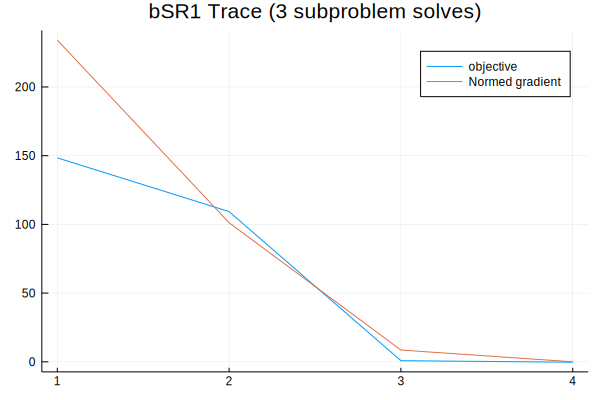

In [97]:
using Plots

n = 10
A = (H = rand(n, n); Symmetric(H'*H + I))
b = rand(n)
f(x) = x'*A*x + b'*x
g!(out, x) = (out = 2 *A*x + b; out)
x0 = ones(n)

xₖ, meta = qntrHS(f, g!, x0; QN=bSR1)

println("bSR1 terminal objective $(last(meta.f_vals))")
println("bSR1 terminal gradient $(last(meta.g_norms))")



plot(1:length(meta.f_vals),
	 [meta.f_vals meta.g_norms],
	 labels=["objective" "Normed gradient"],
	 title="bSR1 Trace ($(meta.k) subproblem solves)",
)	 

## bPSB update on the same problem

This one works occasionally, but often it throws an error in trs_small.
Those that I have encountered are a Domain error, Bounds access error, or an error from trs_small returning two solutions (despite specifying compute_local = true). To avoid the last error, I am arbitraly taking the first column in the returned $aₖ$ from trs_small.




bPSB terminal objective -0.2744691300345858
bPSB terminal gradient 9.122668152877382e-8


┌ Warning: Negative model reduction: -2.4113254036796893e-5 at 4 subproblem solve (Δₖ = 1.0435694442581578, actual reduction: -2.4020185329487465e-5)
└ @ Main In[87]:88
┌ Warning: There is a secant violation: ||HY - S|| = 1.2679310311848945e-7 at 5 subproblem solve
└ @ Main In[87]:68


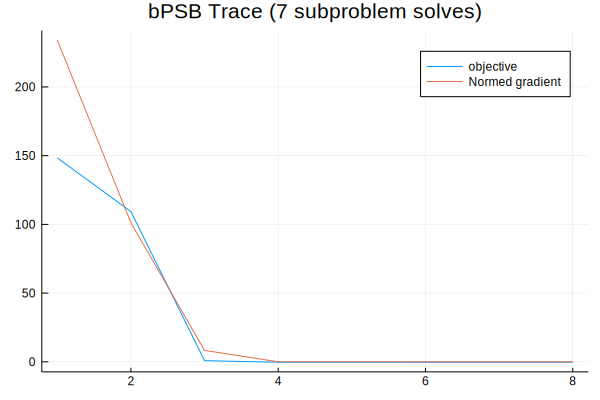

In [100]:
xₖ, meta = qntrHS(f, g!, x0, QN=bPSB)

println("bPSB terminal objective $(last(meta.f_vals))")
println("bPSB terminal gradient $(last(meta.g_norms))")

plot(1:length(meta.f_vals),
	 [meta.f_vals meta.g_norms],
	 labels=["objective" "Normed gradient"],
	 title="bPSB Trace ($(meta.k) subproblem solves)")

## Tesing scheme a POWER (A CUTE problem)

In [101]:
POWER = (x) -> begin
    fx = 0.0
    for i in 1:lastindex(x)
        fx += x[i]^2*i
    end
    
    return fx^2
end

∇POWER = (g, x) -> begin
    α = 0.0
    for i in firstindex(x):lastindex(x)
        α += x[i]^2*i
    end
    for i in firstindex(x):lastindex(x)
        g[i] = 4α*i*x[i]
    end
    return g
end


function simulate(n, b)
    plots = []
    x0 = ones(n)

    result_sr1 = qntrHS(POWER, ∇POWER, x0, d = Driver(n = length(x0 ), s = b, QN = bSR1)); 

    println("bSR1 terminal objective $(last(result_sr1[2].f_vals))")
    println("bSR1 terminal gradient $(last(result_sr1[2].g_norms ))")

    p = plot(1:length(result_sr1[2].f_vals), [result_sr1[2].f_vals result_sr1[2].g_norms],
            labels=["Objective" "Normed gradient"],
            title="bSR1 Trace ($(result_sr1[2].k) iterations)",
            yaxis=:log)

    result_psb = qntrHS(POWER, ∇POWER, x0, d = Driver(n=length(x0), s=b, QN=bPSB)); 
    g = plot(1:length(result_psb[2].f_vals), [result_psb[2].f_vals result_psb[2].g_norms],
            labels=["Objective" "Normed gradient"],
            title="bPSB Trace ($(result_psb[2].k) iterations)",
            yaxis=:log)
    println("bPSB terminal objective $(last(result_psb[2].f_vals ))")
    println("bPSB terminal gradient $(last(result_psb[2].g_norms ))")

    return plot(p, g, layout=(2,1))
end

simulate (generic function with 1 method)

bSR1 terminal objective 9.502957214989717e-10
bSR1 terminal gradient 8.205532680995667e-7
bPSB terminal objective 3.687382804467414e-10
bPSB terminal gradient 3.939968332777184e-7


┌ Warning: There is a secant violation: ||HY - S|| = 1763.1958349438946 at 1 subproblem solve
└ @ Main In[87]:68
┌ Warning: There is a secant violation: ||HY - S|| = 1.2601979808117545 at 3 subproblem solve
└ @ Main In[87]:68
┌ Warning: There is a secant violation: ||HY - S|| = 481.65893375938094 at 1 subproblem solve
└ @ Main In[87]:68
┌ Warning: Negative model reduction: -8.167983415628958e-10 at 30 subproblem solve (Δₖ = 0.000152849010274979, actual reduction: -7.996443895714343e-10)
└ @ Main In[87]:88


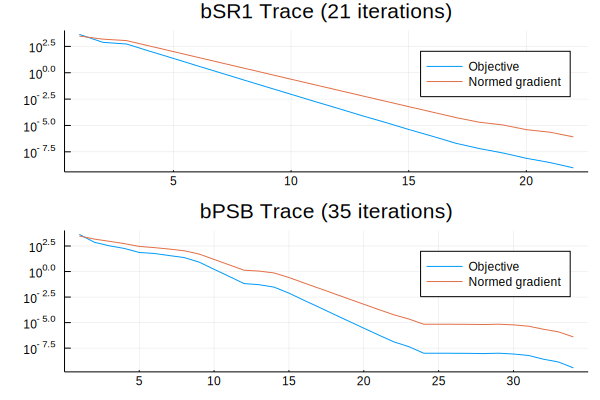

In [102]:
simulate(10, 3)